In [112]:
import qsharp

[[ 0 48 91]
 [48  0 63]
 [91 63  0]]


C:\Users\marlo\AppData\Local\Temp\ipykernel_33996\1999253628.py:11: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(graph).todense()


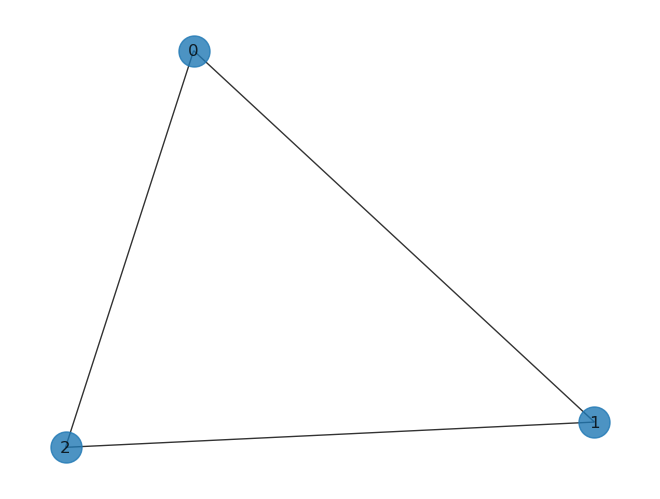

In [113]:
import networkx as nx

graph = nx.Graph()
graph.add_nodes_from([0, 1, 2])
graph.add_weighted_edges_from([(0, 1, 48), (1, 2, 63), (2, 0, 91)])
edge_labels = nx.get_edge_attributes(graph, "weight")
nx.draw(graph, with_labels=True, alpha=0.8, node_size=500)
#nx.draw_networkx_edge_labels(graph, font_color="b", edge_labels=edge_labels)


adjacency = nx.adjacency_matrix(graph).todense()
print(adjacency)


In [128]:
%%qsharp



open Microsoft.Quantum.Canon;
open Microsoft.Quantum.Intrinsic;
open Microsoft.Quantum.Convert;
open Microsoft.Quantum.Math;
open Microsoft.Quantum.Arithmetic;
open Microsoft.Quantum.Preparation;
open Microsoft.Quantum.Diagnostics;

operation getDistanceMatrix():Double[][]{
    return [[ 0., 48., 91.],
            [48.,  0., 63.],
            [91., 63.,  0.]];
}


@EntryPoint()
operation testQAOA():Double{
    let res = meanCost(QAOA(3,1,5.,5.));
    return res;
}

operation testQAOALength5():Double{
    let res = meanCost(QAOALength5Test(5,1,[5.],[5.]));
    return res;
}

operation testQAOAWithX(gamma:Double, beta:Double):Double{
    let res = costAttempt(QAOA(9,1,gamma,beta));
    return res;
}

// operation makeXMatrix (results : Int[]) : Int[][]{
//     mutable sideLength = DoubleAsInt(Sqrt(IntAsDouble(Length(results))));
//     mutable x = [[0, size=sideLength], size=sideLength];
//     for i in 0..sideLength-1{
//         for j in 0.. sideLength-1{
//             set x w/= [i][j] <- results[i+j];
//         }
//     }
//     return x;
// }

operation costAttempt(result:Int[]):Double{
    //D(x)
    let z = Sqrt(IntAsDouble(Length(result)));
    let sideLength = Floor(z);
    //Message($"The side length {sideLength}");
    mutable Dx = 0.0;
    let distances = getDistanceMatrix();
    for i in 0..sideLength-1{
        for j in 0..sideLength-1{
            mutable innerSum = 0.0;
            for t in 0..sideLength-2{
                set innerSum = innerSum + IntAsDouble(result[i+t*sideLength]) + IntAsDouble(result[j+(t+1)*sideLength]);
                //Message($"i+t*sideLength is  {i+t*sideLength}");
                //Message($"j+(t+1)*sideLength is  {j+(t+1)*sideLength}");
            }
            set Dx = Dx + distances[i][j]*innerSum;
        }
    }
    //-----------------------------------------------------------------------------------------------

    //C(x)

    mutable Cx = 0.0;
    let A = 200.;//We need to adjust this parameter A until it works (should be "much larger" than the edge weights)
    mutable innerSum2 = 0.0;
    for i in 0..sideLength-1{
        mutable innerLeft = 0.0;
        for t in 0..sideLength-1{
            set innerLeft += IntAsDouble(result[i+t*sideLength]);
        }
        set innerSum2 = innerSum2 + (1. - innerLeft)^2.;
    }

    for t in 0..sideLength-1{
        mutable innerRight = 0.0;
        for i in 0..sideLength-1{
            set innerRight += IntAsDouble(result[i+t*sideLength]);
        }
        set innerSum2 = innerSum2 + (1. - innerRight)^2.;
    }

    set Cx = Dx + A*innerSum2;
    return Cx;
}

operation QAOA (lengthRegister:Int, p:Int, beta:Double, gamma:Double) : Int[]{

    //input qubits
    use register = Qubit[lengthRegister];

    //prepare qubits by creating uniform superposition
    ApplyToEach(H, register);

    //repeat cost and mixer steps p times
    //I think that we might need a new gamma and beta for each p
    for i in 1..p{
        costHamiltonianFlexible(register, gamma);
        mixerHamiltonian(register, beta);
    }

    //Read the results as a boolean array (true==1, false==0)
    mutable res = new Int[Length(register)];
    for i in 0..Length(register)-1{
        set res w/= i <- (M(register[i]) == One ? 1 | 0);
    }

    //return the results
    return res;
 }

operation QAOALength5Test (lengthRegister:Int, p:Int, beta:Double[], gamma:Double[]) : Int[]{

    //input qubits
    use register = Qubit[lengthRegister];

    //prepare qubits by creating uniform superposition
    ApplyToEach(H, register);

    //repeat cost and mixer steps p times
    //I think that we might need a new gamma and beta for each p
    for i in 1..p{
        costHamiltonianLength5(register, gamma[p-1]);
        mixerHamiltonian(register, beta[p-1]);
    }

    //Read the results as a boolean array (true==1, false==0)
    mutable res = new Int[Length(register)];
    for i in 0..Length(register)-1{
        set res w/= i <- (M(register[i]) == One ? 1 | 0);
    }

    //return the results
    return res;
 }

 operation costHamiltonianLength5 (register:Qubit[], gamma:Double):Unit{
    //Assuming lenght of register is 5
    //I aint commenting this sheet
    let (q0, q1, q2, q3, q4)= (register[0], register[1], register[2], register[3], register[4]);
    CNOT(q1, q0);
    Rz(gamma, q0);
    CNOT(q1, q0);
    CNOT(q2, q0);
    CNOT(q2, q0);
    Rz(gamma, q0);
    CNOT(q2, q0);
    CNOT(q2, q1);
    CNOT(q3, q0);
    Rz(5.*gamma, q0);
    Rz(2.*gamma, q1);
    CNOT(q2, q1);
    CNOT(q3, q0);
    CNOT(q3, q1);
    CNOT(q4, q0);
    Rz(5.*gamma, q0);
    Rz(gamma, q1);
    CNOT(q3, q1);
    CNOT(q4, q0);
    CNOT(q3, q2);
    CNOT(q4, q1);
    Rz(3.*gamma, q1);
    Rz(5.*gamma, q2);
    CNOT(q3, q2);
    CNOT(q4, q1);
    CNOT(q4, q2);
    Rz(gamma, q2);
    CNOT(q4, q2);
    CNOT(q4, q3);
    Rz(5.*gamma, q3);
    CNOT(q4, q3);
 }

//Flexible cost hamiltonian layer
//Misssing weights
operation costHamiltonianFlexible (register : Qubit[], gamma:Double):Unit{         
    ApplyToEach(Rz(gamma, _), register); //Needs weights (melvin will look for what they should be)
    let distances = getDistanceMatrix();
     for i in 0..Length(register)-1{
         for j in i+1..Length(register)-1{
             Rzz(gamma*distances[i][j], register[i], register[j]);
         }
     }
 }

operation mixerHamiltonian (register:Qubit[], beta:Double):Unit{
     //uhhh yeah you just like do this
     ApplyToEach(Rx(2.*beta, _), register);
 }


operation meanCost(x:Int[]):Double{
    mutable res = 0.0;
    //for //i in 0..Length(x)-1{
      //  set res += cost(x[i]);
    //}
    let distances = getDistanceMatrix();
    mutable horizontal = new Double[Length(x)];
    for i in 0..Length(x)-1{
        for j in 0..Length(x)-1{
            set horizontal w/= i <-horizontal[i]+IntAsDouble(x[i])*distances[i][j]; //may be distances[j,i]
        }            
    }

    for k in 0..Length(x)-1{
        set res = res+horizontal[k]*IntAsDouble(x[k]);
    }

    return res;///IntAsDouble(Length(x));
}

operation classicalOptimizerBasic(lastCost:Double, gamma:Double, beta:Double, p:Int, length:Int, learnignRate:Double):(Double, Double){
    mutable g = gamma;
    mutable b = beta;
    mutable min = [gamma, beta];
     mutable newCost = 0.0;
    for i in -1..1{
        if i !=0{
            for j in -1..1{
                if j!= 0{
                    set g = gamma + IntAsDouble(i)*learnignRate;
                    set b = beta + IntAsDouble(j)*learnignRate;
                    set newCost = costFunctionN(g,b);//costAttempt(QAOA(length, p, g, b));
                    if lastCost > newCost{
                        set min = [g, b];
                    } 
                }
            }
        }
    }
    set g = min[0];
    set b = min[1];
    Message($"lastCost {lastCost}");
    Message($"newCost {newCost}");
//     if (g < (gamma-.05) or g > (gamma+.05) or b<(beta-.05) or b>(beta+.05)){
    if (lastCost-newCost > 0.0){
        return classicalOptimizerBasic(costFunctionN(g,b), g, b, p, length, learnignRate);
    }
    return (min[0], min[1]);
}

operation costFunctionN(gamma:Double, beta:Double):Double{
    let numReps = 1000;
    mutable bigArr = new Int[numReps*9];
    mutable numOnes = 0;
    mutable numZeros = 0;
    for i in 0..numReps-1{
        let res = QAOA(9, 1, gamma, beta);
        for j in 0..8{
            set bigArr w/= (9*i+j) <- res[j];
            if(res[j]==1){
                set numOnes+=1;
            }
            elif (res[j]==0){
                set numZeros+=1;
            }
        }
    }
    return (IntAsDouble(numZeros)-IntAsDouble(numOnes))/IntAsDouble(numReps);    
}
    
operation test(x: Double, y:Double, z:Int):Double{
    return 100.0;
}
     

D:\snippet_.qs(107,19): warning QS3308: Deprecated syntax. Use [] to construct an empty array, or [x, size = n] to construct an array of x repeated n times.
D:\snippet_.qs(132,19): warning QS3308: Deprecated syntax. Use [] to construct an empty array, or [x, size = n] to construct an array of x repeated n times.
D:\snippet_.qs(202,26): warning QS3308: Deprecated syntax. Use [] to construct an empty array, or [x, size = n] to construct an array of x repeated n times.
D:\snippet_.qs(248,22): warning QS3308: Deprecated syntax. Use [] to construct an empty array, or [x, size = n] to construct an array of x repeated n times.


In [115]:
import numpy as np
from scipy.optimize import minimize

In [116]:
myP=1
print(QAOA.simulate(lengthRegister=9, p=myP, gamma=1, beta=1))
print(QAOA.simulate(lengthRegister=9, p=myP, gamma=1, beta=1))
print(QAOA.simulate(lengthRegister=9, p=myP, gamma=1, beta=1))
print(QAOA.simulate(lengthRegister=9, p=myP, gamma=1, beta=1))
print(QAOA.simulate(lengthRegister=9, p=myP, gamma=1, beta=1))
print(QAOA.simulate(lengthRegister=9, p=myP, gamma=1, beta=1))
print(QAOA.simulate(lengthRegister=9, p=myP, gamma=1, beta=1))
print(QAOA.simulate(lengthRegister=9, p=myP, gamma=1, beta=1))
print(QAOA.simulate(lengthRegister=9, p=myP, gamma=1, beta=1))
print(QAOA.simulate(lengthRegister=9, p=myP, gamma=1, beta=1))
print(QAOA.simulate(lengthRegister=9, p=myP, gamma=1, beta=1))
print(QAOA.simulate(lengthRegister=9, p=myP, gamma=1, beta=1))

[1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 0, 0, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 0]
[1, 0, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 0, 0]
[1, 0, 0, 1, 1, 0, 0, 0, 1]
[1, 1, 1, 0, 1, 1, 1, 1, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 1, 0, 0]
[1, 1, 1, 1, 1, 1, 0, 1, 1]
[1, 1, 1, 1, 1, 1, 0, 1, 0]


In [117]:
# def optimize(gammaIn, betaIn, LR):
#     print(testQAOAWithX.simulate(gamma=gammaIn, beta=gammaIn))
#     prevCost = testQAOAWithX.simulate(gamma=1, beta=1.7)
#     arr = classicalOptimizerBasic.simulate(lastCost=prevCost, gamma=1, beta=1.7, p=1, length=9, learnignRate=LR)
#     g = arr[0]
#     b=arr[1]
#     print("g=", g)
#     print("b=", b)
#     print(testQAOAWithX.simulate(gamma=g, beta=b))
    
#     #if(g < (gammaIn-.01) and g > (gammaIn+.01) and b<(betaIn-.01) and b>(betaIn+.01)):
#     if(g != gammaIn and b != betaIn):
#         optimize(g,b, LR/1.1)
#     else:
#         return
        
# optimize(1, 1.7, .01)

g=11.7
b=11.7
print("pre optimize", testQAOAWithX.simulate(gamma=g, beta=b))
preCost=costFunctionN.simulate(gamma=g,beta=b)
arr=classicalOptimizerBasic.simulate(lastCost=preCost, gamma=g, beta=b, p=1, length=9, learnignRate=0.05)
g = arr[0]
b=arr[1]
print("post optimize:", testQAOAWithX.simulate(gamma=g, beta=b))
# print(testQAOAWithX.simulate(gamma=g, beta=b))
# print(testQAOAWithX.simulate(gamma=g, beta=b))



print("-----")

# print(costAttempt.simulate(result=[1,1,0,0,1,0,0,1,0]))
# print(costAttempt.simulate(result=[1,0,1,0,1,0,0,0,1]))
# print(costAttempt.simulate(result=[0,1,1,0,1,0,0,0,1]))
# print(costAttempt.simulate(result=[1,0,0,0,1,1,1,1,1]))
# print(costAttempt.simulate(result=[0,0,0,0,0,0,0,0,1]))

print("Ideal:",costAttempt.simulate(result=[1,0,0,0,1,0,0,0,1])) #ideal

pre optimize 2975.0
lastCost -0.154
newCost -0.106
post optimize: 911.0
-----
Ideal: 515.0


In [118]:
def getMostFrequent(gamma, beta):
    myDict = {}
    for i in range(2000):
        res = QAOA.simulate(lengthRegister=9, p=1, gamma=gamma, beta=beta)
        res=tuple(res)
        if res in myDict.keys():
            myDict.update({res:myDict.get(res)+1})
        else:
            myDict.update({res:0})
    
#     return max(myDict.values())
    #print(myDict)
    return max(myDict)
print(getMostFrequent(g,b))

(1, 1, 1, 1, 1, 1, 1, 1, 1)


In [125]:
#def obj_func(angles):
#    gamma, beta = angles
#    return meanCost.simulate(x=QAOA.simulate(measure=[true, true, true, true, true], p=1, g=gamma, b=beta))

def obj_func(params):
    my_res = (costFunctionN.simulate(gamma=params[0], beta=params[1]))
    print(params)

# Initial guess for the parameters
initial_guess = [3.0, 11.0]


# Perform optimization
result = minimize(obj_func, initial_guess, method="COBYLA")
print(result)

# Extract the optimized parameters
optimized_params = result.x
print(optimized_params)

[ 3. 11.]
[ 4. 11.]
[ 3. 12.]
[ 3.125 11.   ]
[ 3.    11.125]
[ 3.015625 11.      ]
[ 3.       11.015625]
[ 3.00195312 11.        ]
[ 3.         11.00195312]
[ 3.00024414 11.        ]
[ 3.         11.00024414]
[ 3.00005 11.     ]
[ 3.      11.00005]
     fun: 0.0
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 13
  status: 1
 success: True
       x: array([ 3., 11.])
[ 3. 11.]


In [120]:
from scipy.optimize import minimize
import networkx as nx

In [121]:
def main():
    
    expectation = testQAOAWithX.simulate()
    res = minimize(expectation,[1.0, 1.0], method='COBYLA')

    return res ## optimized values

main()


Received invalid parameters. Please fix and try again:
 gamma: missing.
 beta: missing.


TypeError: 'NoneType' object is not callable